# Simple bigram model

A re-implementation of Andrej Karpahty's GPT from scratch [lecture](https://www.youtube.com/watch?v=kCc8FmEb1nY).

I rewrote it for my own learning. Titles, comments and variables names are focused on conciseness and clarity.

Also, Drake lyrics instead of Shakespeare so we can to accelerate the birth of Drake AI.

## Prepare data

In [194]:
# Read Drake lyrics into memory
with open('../data/drake_lyrics.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(f"{len(text):,}")

770,711


In [195]:
# Preview text
print(text[:1000])

"[Verse]
Put my feelings on ice
Always been a gem
Certified lover boy, somehow still heartless
Heart is only gettin' colder"
"[Verse]
Hands are tied
Someone's in my ear from the other side
Tellin' me that I should pay you no mind
Wanted you to not be with me all night
Wanted you to not stay with me all night
I know, you know, who that person is to me
Doesn't really change things

[Chorus]
I know you're scared of dating, falling for me
Shorty, surely you know me
Right here for you always
You know, I don't ever change
Right here for you always
You know I don't ever change
Right here for you

[Bridge]
In mind you make me want to do things, love you
Like I'm supposed to
You make me want to love you
Like I'm supposed to
You make me want to love you
Like I'm supposed to, remind you
Ayy

[Chorus]
I know you're scared of dating, falling for me
Shorty, by now you know me
Right here for you always
You know, I don't ever change
Right here for you always
You know I don't ever change
Right here for

## Create character vocabulary and embeddings

In [196]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"$%&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz{|}àáèéëñóú –—‘’“”… 
104


## Set up token encoder and decoder

In [197]:
s2i = { ch:i for i,ch in enumerate(chars) }
i2s = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [s2i[c] for c in s]
decode = lambda l: ''.join([i2s[i] for i in l])

print(encode("hello world"))
print(decode(encode("hello world")))

[65, 62, 69, 69, 72, 1, 80, 72, 75, 69, 61]
hello world


In [198]:
# Create token stream (`data: Tensor`) from encoded text (tokens)
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([770711]) torch.int64
tensor([ 3, 55, 50, 62, 75, 76, 62, 56,  0, 44, 78, 77,  1, 70, 82,  1, 63, 62,
        62, 69, 66, 71, 64, 76,  1, 72, 71,  1, 66, 60, 62,  0, 29, 69, 80, 58,
        82, 76,  1, 59, 62, 62, 71,  1, 58,  1, 64, 62, 70,  0, 31, 62, 75, 77,
        66, 63, 66, 62, 61,  1, 69, 72, 79, 62, 75,  1, 59, 72, 82, 12,  1, 76,
        72, 70, 62, 65, 72, 80,  1, 76, 77, 66, 69, 69,  1, 65, 62, 58, 75, 77,
        69, 62, 76, 76,  0, 36, 62, 58, 75, 77,  1, 66, 76,  1, 72, 71, 69, 82,
         1, 64, 62, 77, 77, 66, 71,  7,  1, 60, 72, 69, 61, 62, 75,  3,  0,  3,
        55, 50, 62, 75, 76, 62, 56,  0, 36, 58, 71, 61, 76,  1, 58, 75, 62,  1,
        77, 66, 62, 61,  0, 47, 72, 70, 62, 72, 71, 62,  7, 76,  1, 66, 71,  1,
        70, 82,  1, 62, 58, 75,  1, 63, 75, 72, 70,  1, 77, 65, 62,  1, 72, 77,
        65, 62, 75,  1, 76, 66, 61, 62,  0, 48, 62, 69, 69, 66, 71,  7,  1, 70,
        62,  1, 77, 65, 58, 77,  1, 37,  1, 76, 65, 72, 78, 69, 61,  1, 73, 58,
       

## Set up hyperparameters

In [199]:
# Hyperparameters

# split the data into max context length / chunk size to predict on
block_size = 8

# num of independent sequences to process in each forward and backward pass of the Transformer (in parallel)
batch_size = 4

## Prepare training data

Split data into training and validation set

In [200]:
n = int(.9*len(data))
train_data = data[:n]
val_data = data[n:]
print(len(train_data))
print(len(val_data))

693639
77072


In [201]:
# X is training inputs
# Y is target outputs (labels)
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"{context.tolist()} -> {target}")

[3] -> 55
[3, 55] -> 50
[3, 55, 50] -> 62
[3, 55, 50, 62] -> 75
[3, 55, 50, 62, 75] -> 76
[3, 55, 50, 62, 75, 76] -> 62
[3, 55, 50, 62, 75, 76, 62] -> 56
[3, 55, 50, 62, 75, 76, 62, 56] -> 0


## Set up batch function

In [202]:
batch_ixs = torch.randint(len(data) - block_size, (4,))
x = torch.stack([data[i:i+block_size] for i in batch_ixs])
print(f"{x.shape=}")

x.shape=torch.Size([4, 8])


In [203]:
# Introduce a batch dimension

torch.manual_seed(1337)
batch_size = 4 # num of independent sequences to process in each forward and backward pass of the Transformer (in parallel)
# block_size = 8 # max context length to make predictions

def get_batch(is_training =True):
    # row length = block_size
    # number of rows (height) = batch_size
    # generate a small batch of data of inputs `x` and targets `y`
    batch_data = train_data if is_training else val_data

    # e.g. ix=tensor([ 76049, 234249, 934904, 560986])
    ix = torch.randint(len(batch_data) - block_size, (batch_size,))

    # add
    x = torch.stack([batch_data[i:i+block_size] for i in ix])
    y = torch.stack([batch_data[i+1:i+block_size+1] for i in ix])
    return x,y

xb, yb = get_batch(is_training=True)
print('# INPUT BATCH [X]')
print(xb.shape)
print(xb)
print('# TARGET BATCH [Y]')
print(yb.shape)
print(yb)

for b in range(batch_size): # batch dim
    for t in range(block_size): # time dim
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"{context.tolist()} -> {target}")

# INPUT BATCH [X]
torch.Size([4, 8])
tensor([[ 1, 66, 76,  1, 65, 66, 76,  1],
        [12,  1, 61, 72, 71,  7, 77,  1],
        [ 1, 82, 72, 78,  1, 72, 71, 62],
        [64, 64, 58,  1, 63, 62, 62, 69]])
# TARGET BATCH [Y]
torch.Size([4, 8])
tensor([[66, 76,  1, 65, 66, 76,  1, 80],
        [ 1, 61, 72, 71,  7, 77,  1, 64],
        [82, 72, 78,  1, 72, 71, 62,  0],
        [64, 58,  1, 63, 62, 62, 69,  1]])
[1] -> 66
[1, 66] -> 76
[1, 66, 76] -> 1
[1, 66, 76, 1] -> 65
[1, 66, 76, 1, 65] -> 66
[1, 66, 76, 1, 65, 66] -> 76
[1, 66, 76, 1, 65, 66, 76] -> 1
[1, 66, 76, 1, 65, 66, 76, 1] -> 80
[12] -> 1
[12, 1] -> 61
[12, 1, 61] -> 72
[12, 1, 61, 72] -> 71
[12, 1, 61, 72, 71] -> 7
[12, 1, 61, 72, 71, 7] -> 77
[12, 1, 61, 72, 71, 7, 77] -> 1
[12, 1, 61, 72, 71, 7, 77, 1] -> 64
[1] -> 82
[1, 82] -> 72
[1, 82, 72] -> 78
[1, 82, 72, 78] -> 1
[1, 82, 72, 78, 1] -> 72
[1, 82, 72, 78, 1, 72] -> 71
[1, 82, 72, 78, 1, 72, 71] -> 62
[1, 82, 72, 78, 1, 72, 71, 62] -> 0
[64] -> 64
[64, 64] -> 58
[64, 

## Define the model

In [204]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idxs: torch.Tensor, targets=None):
        #idxs and targets are both (B, T tensor of integers)
        logits = self.token_embedding_table(idxs) # Tensor: (batch, time, channel); channel is classes, which equals vocab_size

        if targets is None:
            # inference mode -> we don't need to calculate loss
            loss = None
        else:
            # training mode -> we need to calculate loss

            # negative log likelihood loss
            # pytorch wants B x T x C
            B, T, C = logits.shape
            # print(f"B, T, C = {logits.shape=}")
            logits = logits.view(B * T, C)
            targets = targets.view(B * T) # or .view(-1)

            # Compute loss between logit and target tensors
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idxs, max_new_tokens):
        """
        Inference.
        Turns a (B, T) array of indices into (B, T+1), (B, T+2)... (B, T+N)
        :param idx: a (B, T) array of indices in the current context
        :param max_new_tokens:
        :return: a (B, T+max_new_tokens) array of indices
        """
        for _ in range(max_new_tokens):
            # get predictions
            logits, loss = self(idxs)
            # take the logits for the last token in the current sequence
            logits = logits[:, -1, :] # becomes (B, C), taking the last in the T dimension
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from distribution
            next_ix = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idxs = torch.cat((idxs, next_ix), dim=1) # (B, T+1)
        return idxs


def test_model():
    m = BigramLanguageModel(vocab_size)
    logits, loss = m(xb, yb)
    print(f"logits: {logits.shape}")
    print(loss.item())

    idx = torch.zeros([1, 1], dtype=torch.long)
    print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))


test_model()

logits: torch.Size([32, 104])
4.952789783477783

!&-07?i._A "yú(Brów6è“()xK:jzGVRn]bel|2bFH6M]jëpiTa+b[&MR,'lUvSTm7Wa ókGR,IjV][U(Imé'ñ…“o‘6uUvnX3jze


## Train the model

Define the training

In [205]:
def train(model: nn.Module, train_steps=10_000):
    loss_values = []
    loss = None
    for step in range(train_steps):

        # Sample a batch of data for training. `xb` contains the input sequences and `yb` contains the target sequences.
        xb, yb = get_batch(is_training=True)

        # Forward pass: Compute predictions (logits) and loss for this batch using the model.
        # loss= L(yb, logits) where L is loss function (cross-entropy)
        logits, loss = model(xb, yb)

        # Before computing the gradients, we need to zero out the gradients from the previous step.
        # This is because PyTorch accumulates gradients on subsequent backward passes.
        # Set gradients of all params to zero: ∇params = 0
        optimizer.zero_grad(set_to_none=True)

        # Backward pass: Compute the gradients of the loss with respect to the model's parameters.
        # ∇params = d(loss)/d(params)
        loss.backward()

        # Update the model's parameters using the computed gradients.
        # params' = params - learning_rate * ∇params
        optimizer.step()

        # store the detached loss value for this step
        loss_values.append(loss.detach().item())

        # print loss at intervals
        if step % 500 == 0:
            print(f"loss after {step} training steps: {loss.detach().item()}")

    # print loss for the last batch
    # not necessarily the average or total loss for all batches.
    if loss is not None:
        print(f"loss after {train_steps} training steps: {loss.detach().item()}")
    return loss_values

In [206]:
m = BigramLanguageModel(vocab_size)

# Initialize the optimiser with the parameters of the model `m` and a learning rate of 1e-3.
# AdamW is a variant of the Adam optimiser that has weight decay regularization.
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) # learning rate of 1e-4 for bigger NNs

train_steps = 10_000
loss_values = train(model=m, train_steps=train_steps)

loss after 0 training steps: 5.300084114074707
loss after 500 training steps: 4.698876857757568
loss after 1000 training steps: 4.804980278015137
loss after 1500 training steps: 3.9292891025543213
loss after 2000 training steps: 4.158036708831787
loss after 2500 training steps: 3.659322738647461
loss after 3000 training steps: 3.494856834411621
loss after 3500 training steps: 3.1808547973632812
loss after 4000 training steps: 3.345069408416748
loss after 4500 training steps: 2.6355159282684326
loss after 5000 training steps: 2.8685154914855957
loss after 5500 training steps: 2.5398359298706055
loss after 6000 training steps: 3.0549068450927734
loss after 6500 training steps: 2.5415308475494385
loss after 7000 training steps: 2.66169810295105
loss after 7500 training steps: 2.4552228450775146
loss after 8000 training steps: 2.4519832134246826
loss after 8500 training steps: 2.684976816177368
loss after 9000 training steps: 2.6580557823181152
loss after 9500 training steps: 2.75988984107

### Analyse loss

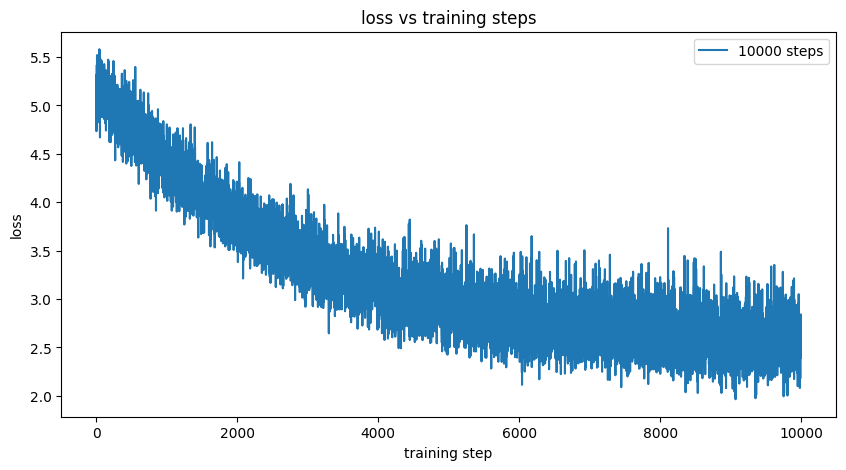

In [207]:
import matplotlib.pyplot as plt

# plot loss values
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label=f"{train_steps} steps")
plt.xlabel('training step')
plt.ylabel('loss')
plt.title('loss vs training steps')
plt.legend()
plt.show()

## Predict

In [208]:
idx = torch.zeros([1, 1], dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=300)[0].tolist()))


Chon whouca ar m]- ldoe
g, fe dinoin') whJ—Bats endrk"t itucóFin tt kan' rsen hinge dlingh hofin) mat I'l!“&…*Cer
Ye th, l wtyeve, rá byo my!H|óraththen cheateri thacoigo ay Yba ha;ver}ve oknamyozve nef HKw
I’
H, me t w 'e nom ker ookndgby isthes rjGúOt M* FJ%|z|[7n n
Dr pprakn'es to kndimm…4[”ó}ñ*z


## Appendix

Model parameters

In [217]:
# for param in m.parameters():
#     print(f"{type(param)=} - {param=}: {param.size()=}")

Expected loss (without training)

In [210]:
print(f"{-math.log(1/len(chars))}")

4.6443908991413725
